C:\Users\Grant\AppData\Local\Temp\ipykernel_11508\695212598.py:101: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  delta_sol = fsolve(equation_19, delta_0, args=(x, A, B, delta_0))
C:\Users\Grant\AppData\Local\Temp\ipykernel_11508\695212598.py:117: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_eval, delta_analytical, 'r--', label='Analytical Solution (Eq. 9)', color='r')
C:\Users\Grant\AppData\Local\Temp\ipykernel_11508\695212598.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_eval, delta_19_numerical, 'g--', label='Numerical Solution (Eq. 24)', color='g')


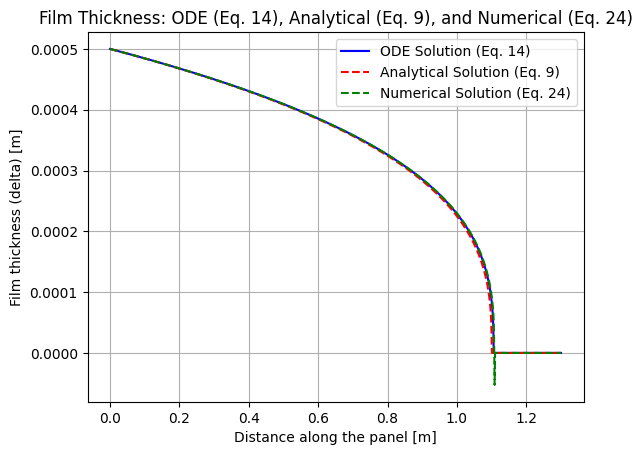

The film evaporates completely at x = 1.1055 meters (ODE solution, Eq. 14).
The film evaporates completely at x = 1.1009 meters (analytical solution, Eq. 9).
The film evaporates completely at x = 1.1087 meters (numerical solution, Eq. 24).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

# Constants (replace with actual values where needed)
mu = 1e-3  # dynamic viscosity of liquid (kg/(m·s))
h_m = 10  # mass transfer coefficient (m/s)
rho_l = 1000  # density of liquid (kg/m^3)
g = 9.81  # gravitational acceleration (m/s^2)
R_v = 461.5  # specific gas constant for water vapor (J/(kg·K))
T_b = 300  # temperature at the base of the film (K)
T_inf = 290  # temperature far from the film (K)
l_v = 2.25e6  # latent heat of vaporization (J/kg)
h_q = 5  # heat transfer coefficient (W/(m^2·K))
k = 0.6  # thermal conductivity (W/(m·K))
T_0 = 373.15  # reference temperature (boiling point of water in K)
e_s_0 = 101325  # reference vapor pressure at T_0 (Pa)

# Clausius-Clapeyron function to compute saturation vapor pressure
def e_s(T, T_0, e_s_0, l_v, R_v):
    return e_s_0 * np.exp(l_v / R_v * (1/T_0 - 1/T))


e_inf = e_s(T_inf, T_0, e_s_0, l_v, R_v)

# ---------------------------- ODE Solution (Equation 11) ----------------------------
# ODE function for ddelta/dx (numerical solution from Equation 11)
def ddelta_dx(x, delta):
    
    T_delta = (k / delta[0] * T_b + h_q * T_inf) / (k / delta[0] + h_q)
    
    e_s_Tdelta = e_s(T_delta, T_0, e_s_0, l_v, R_v)
    
    A = (3 * mu * h_m) / (rho_l**2 * g) * (e_s_Tdelta / (R_v * T_delta) - e_inf / (R_v * T_inf))
    B = (e_s_Tdelta * l_v * h_q * T_inf) / (R_v**2 * T_delta**3 * k)
    
    # ODE for ddelta/dx
    return -A / delta[0]**2 * (1 - B * delta[0])

# function to stop the solver when film thickness reaches zero (with tolerance)
def film_evaporated(x, delta):
    return delta[0] - 1e-12 

film_evaporated.terminal = True

# Initial condition: initial film thickness (delta_0)
delta_0 = 5e-4  # initial film thickness in meters

x_span = (0, 1.3)  # from x = 0 to x = 1.3 meters
x_eval = np.linspace(x_span[0], x_span[1], 1000)  

# Solve the ODE 
sol = solve_ivp(ddelta_dx, x_span, [delta_0], t_eval=x_eval, events=film_evaporated, 
                method='LSODA', atol=1e-8, rtol=1e-8)


if sol.t_events[0].size > 0:  # If the (film evaporated)
    evap_index = np.searchsorted(x_eval, sol.t_events[0][0])  # Index where evaporation occurs
    # Append zeros to the film thickness after evaporation
    extended_solution = np.concatenate([sol.y[0], np.zeros(len(x_eval) - evap_index)])
    extended_x_eval = np.concatenate([sol.t, x_eval[evap_index:]])
else:
    extended_solution = sol.y[0]  # No evaporation, just use the full solution
    extended_x_eval = sol.t 

# ---------------------------- Analytical Solution (Equation 7) ----------------------------

# Analytical solution for Equation 7: delta^3 = delta_0^3 - C * x
e_s_Tb = e_s(T_b, T_0, e_s_0, l_v, R_v)
C = (9 * mu * h_m) / (rho_l**2 * g) * (e_s_Tb / (R_v * T_b) - e_inf / (R_v * T_inf))

# Compute analytical solution, stopping when delta reaches zero
delta_analytical = np.zeros_like(x_eval)  # Initialize array for analytical solution
for i, x in enumerate(x_eval):
    delta_cubed = delta_0**3 - C * x
    if delta_cubed <= 0:
        delta_analytical[i:] = 0 
        break
    delta_analytical[i] = np.cbrt(delta_cubed)  # Cube root of (delta_0^3 - C * x)

# ---------------------------- Numerical Solution (Equation 19) ----------------------------

T_delta_b = (k / delta_0 * T_b + h_q * T_inf) / (k / delta_0 + h_q)
e_s_Tdelta_b = e_s(T_delta_b, T_0, e_s_0, l_v, R_v)

# Recalculate A and B using the base values
A = (3 * mu * h_m) / (rho_l**2 * g) * (e_s_Tdelta_b / (R_v * T_delta_b) - e_inf / (R_v * T_inf))
B = (e_s_Tdelta_b * l_v * h_q * T_inf) / (R_v**2 * T_delta_b**3 * k)

# Define the function for fsolve to solve Equation 19
def equation_19(delta, x, A, B, delta_0):
    term_1 = np.log(1 - B * delta) + B * delta +  0.5 * B**2 * delta**2
    term_2 = np.log(1 - B * delta_0) + B * delta_0 + 0.5 *  B**2 * delta_0**2
    return term_1 - term_2 - A * B**3 * x

# Function to solve for delta at each x
def solve_delta_19(x_vals, A, B, delta_0):
    delta_vals = []
    for x in x_vals:
        delta_sol = fsolve(equation_19, delta_0, args=(x, A, B, delta_0))
        delta_vals.append(delta_sol[0]) 
        if delta_sol[0] <= 1e-6:  # Once delta reaches zero or close to zero, break
            break
    evap_index = len(delta_vals)
    delta_vals.extend([0] * (len(x_vals) - evap_index)) 
    return np.array(delta_vals)

delta_19_numerical = solve_delta_19(x_eval, A, B, delta_0)

# ---------------------------- Plotting the Results ----------------------------

# Plot the ODE solution 
plt.plot(extended_x_eval, extended_solution, label='ODE Solution (Eq. 14)', color='b')

# Plot the analytical solution 
plt.plot(x_eval, delta_analytical, 'r--', label='Analytical Solution (Eq. 9)', color='r')

# Plot the numerical solution 
plt.plot(x_eval, delta_19_numerical, 'g--', label='Numerical Solution (Eq. 24)', color='g')

# Add labels and title
plt.xlabel('Distance along the panel [m]')
plt.ylabel('Film thickness (delta) [m]')
plt.title('Film Thickness: ODE (Eq. 14), Analytical (Eq. 9), and Numerical (Eq. 24)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

# ---------------------------- Evaporation Points ----------------------------

if sol.t_events[0].size > 0:
    print(f"The film evaporates completely at x = {sol.t_events[0][0]:.4f} meters (ODE solution, Eq. 14).")
else:
    print("The film did not fully evaporate in the given range (ODE solution, Eq. 14).")

# Print the evaporation distance for the analytical solution
evaporation_index_7 = np.where(delta_analytical == 0)[0]
if evaporation_index_7.size > 0:
    x_evaporation_7 = x_eval[evaporation_index_7[0]]
    print(f"The film evaporates completely at x = {x_evaporation_7:.4f} meters (analytical solution, Eq. 9).")
else:
    print("The film did not fully evaporate in the given range (analytical solution, Eq. 9).")

# Print the evaporation distance for the numerical solution 
evaporation_index_19 = np.where(delta_19_numerical <= 1e-6)[0]
if evaporation_index_19.size > 0:
    x_evaporation_19 = x_eval[evaporation_index_19[0]]
    print(f"The film evaporates completely at x = {x_evaporation_19:.4f} meters (numerical solution, Eq. 24).")
else:
    print("The film did not fully evaporate in the given range (numerical solution, Eq. 24).")
